### Your name:

<pre>Gary Kane</pre>

### Collaborators:

<pre>Harini Valluru</pre>


In [1]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:

import os
import tarfile
from six.moves import urllib
import re
import numpy as np
import pandas as pd
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


### Classification

**Build a classification model for the default of credit card clients dataset.**

More info here: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The process and questions you need to think about while coding (you should write your response at the cell in the end part of the notebook)

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one we used in classification notebook.
- Study the ROC Curve, decide threshold
- Use 2 classifiers and cross-validation with 5-folds.
    - Random Forest
        - tune only: n_estimators: {4, 5, 10, 20, 50} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 5, 10, 20} 
    - For other paramenters, use default
- Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



In [3]:
df = pd.read_excel("datasets/default of credit card clients.xls", skiprows= 1, header = 0)
df_explore = df.copy()
display(df.head())


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.shape

(30000, 25)

In [5]:
df_explore.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# sort by dtype, we'll mostly treat the numerics the same though

dep_var = ['default payment next month']

categorical_vars = ['SEX','EDUCATION','MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

discrete_vars = ['ID', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5','BILL_AMT6','PAY_AMT1', 'PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

continuous_vars = ['AGE']

In [8]:
import numpy as np

df = df.replace('?',np.NaN)

print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))

print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Number of instances = 30000
Number of attributes = 25
Number of missing values:
	ID: 0
	LIMIT_BAL: 0
	SEX: 0
	EDUCATION: 0
	MARRIAGE: 0
	AGE: 0
	PAY_0: 0
	PAY_2: 0
	PAY_3: 0
	PAY_4: 0
	PAY_5: 0
	PAY_6: 0
	BILL_AMT1: 0
	BILL_AMT2: 0
	BILL_AMT3: 0
	BILL_AMT4: 0
	BILL_AMT5: 0
	BILL_AMT6: 0
	PAY_AMT1: 0
	PAY_AMT2: 0
	PAY_AMT3: 0
	PAY_AMT4: 0
	PAY_AMT5: 0
	PAY_AMT6: 0
	default payment next month: 0


In [9]:
df_explore.loc[:, dep_var + discrete_vars + continuous_vars].describe()

,default payment next month,ID,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.221200,15000.500000,167484.322667,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,35.485500
std,0.415062,8660.398374,129747.661567,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,9.217904
min,0.000000,1.000000,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,21.000000
25%,0.000000,7500.750000,50000.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,28.000000
50%,0.000000,15000.500000,140000.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,34.000000
75%,0.000000,22500.250000,240000.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,41.000000
max,1.000000,30000.000000,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,79.000000


# Feature engineering
The data has been already encoded and cleaned. However, some categorical data have repeated categories. For instance, the variable ‘education’ has three categories with similar information:
4: others, 5: unknown, and 6: unknown
Similarly, the column 'marriage' should have three categories: 1 = married, 2 = single, 3 = others but it contains a category '0' which will be joined to the category '3'.

In [10]:
E = df['EDUCATION'].unique()
M = df['MARRIAGE'].unique()
print(E)
print(M)

[2 1 3 5 4 6 0]
[1 2 3 0]


In [11]:
df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])

df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])

In [12]:
E_N = df['EDUCATION'].unique()
M_N = df['MARRIAGE'].unique()
print(E_N)
print(M_N)

[2 1 3 4]
[1 2 3]


In [13]:
from pandas import set_option

set_option('display.width', 100)
set_option('precision', 2)

print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
print()
print(df.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS

                              count       mean        std       min       25%       50%  \
ID                          30000.0   15000.50    8660.40       1.0   7500.75   15000.5   
LIMIT_BAL                   30000.0  167484.32  129747.66   10000.0  50000.00  140000.0   
SEX                         30000.0       1.60       0.49       1.0      1.00       2.0   
EDUCATION                   30000.0       1.84       0.74       1.0      1.00       2.0   
MARRIAGE                    30000.0       1.56       0.52       1.0      1.00       2.0   
AGE                         30000.0      35.49       9.22      21.0     28.00      34.0   
PAY_0                       30000.0      -0.02       1.12      -2.0     -1.00       0.0   
PAY_2                       30000.0      -0.13       1.20      -2.0     -1.00       0.0   
PAY_3                       30000.0      -0.17       1.20      -2.0     -1.00       0.0   
PAY_4                       30000.0      -0.22     

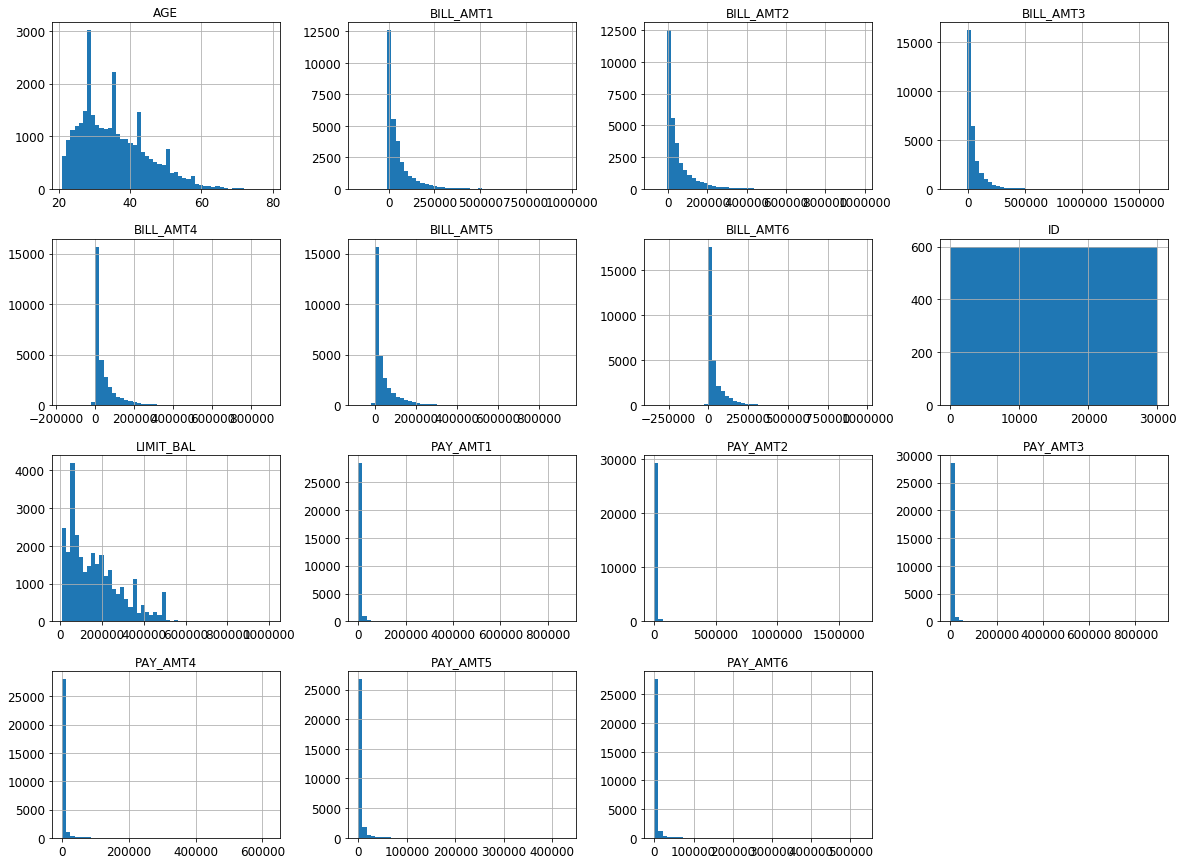

In [14]:
df_explore.loc[:, discrete_vars + continuous_vars].hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
df_explore.rename(columns={"default payment next month": "Default"}, inplace=True)


In [16]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
Default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [17]:
# The frequency of defaults
yes = df_explore.Default.sum()
no = len(df_explore)-yes

# Percentage
yes_perc = round(yes/len(df_explore)*100, 1)
no_perc = round(no/len(df_explore)*100, 1)

print(yes_perc)
print(no_perc)

22.1
77.9


In [20]:
df_explore.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default      0
dtype: int64

In [21]:
df_explore["Default"].value_counts()

0    23364
1     6636
Name: Default, dtype: int64

In [22]:
df_explore["Default"].sum() / len(df_explore["Default"])

0.2212

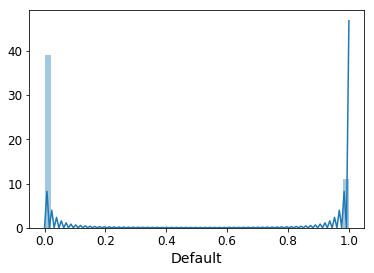

In [23]:
sns.distplot(df_explore['Default'])

In [25]:
# Convert categorical variable into dummy/indicator variables.
credit_dum = pd.get_dummies(df_explore)
credit_dum.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [26]:
# One-hot-encode all category features
print(df_explore[['SEX']].values)
tfmr = OneHotEncoder(sparse=False)
print(tfmr.fit_transform(df_explore[['SEX']].values))

[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [27]:
# Bill Statement description
df_explore[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00
mean,51223.33,49179.08,4.70e+04,43262.95,40311.40,38871.76
std,73635.86,71173.77,6.93e+04,64332.86,60797.16,59554.11
min,-165580.00,-69777.00,-1.57e+05,-170000.00,-81334.00,-339603.00
25%,3558.75,2984.75,2.67e+03,2326.75,1763.00,1256.00
50%,22381.50,21200.00,2.01e+04,19052.00,18104.50,17071.00
75%,67091.00,64006.25,6.02e+04,54506.00,50190.50,49198.25
max,964511.00,983931.00,1.66e+06,891586.00,927171.00,961664.00


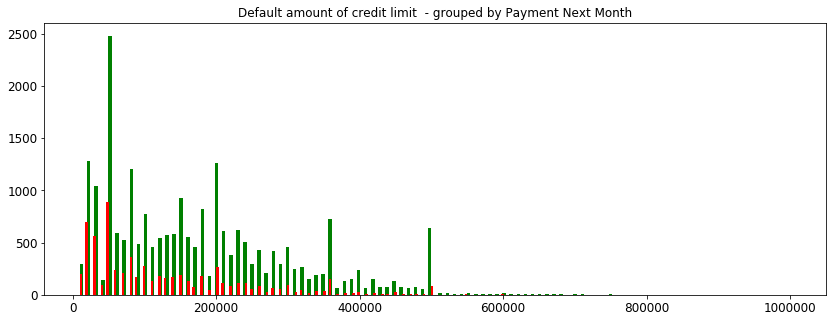

In [28]:

class_0 = df_explore.loc[df_explore["Default"] == 0]["LIMIT_BAL"]
class_1 = df_explore.loc[df_explore["Default"] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,5))
plt.title('Default amount of credit limit  - grouped by Payment Next Month')
plt.hist(class_0, bins=200, color="green")
plt.hist(class_1, bins=200, color="red")
plt.show()

In [29]:
print('LIMIT_BAL :', df[['LIMIT_BAL']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized LIMIT_BAL :', tfmr.fit_transform(df[['LIMIT_BAL']].values)[:, 0])

print('BILL_AMT1 :', df[['BILL_AMT1']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized BILL_AMT1 :', tfmr.fit_transform(df[['BILL_AMT1']].values)[:, 0])

print('BILL_AMT2 :', df[['BILL_AMT2']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized BILL_AMT2 :', tfmr.fit_transform(df[['BILL_AMT2']].values)[:, 0])

print('BILL_AMT3 :', df[['BILL_AMT3']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized BILL_AMT3 :', tfmr.fit_transform(df[['BILL_AMT3']].values)[:, 0])

print('BILL_AMT4 :', df[['BILL_AMT4']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized BILL_AMT4:', tfmr.fit_transform(df[['BILL_AMT4']].values)[:, 0])

print('BILL_AMT5:',df[['BILL_AMT5']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized BILL_AMT5:', tfmr.fit_transform(df[['BILL_AMT5']].values)[:, 0])

print('BILL_AMT6:', df[['BILL_AMT6']].values[:, 0])
tfmr =  MinMaxScaler()
print('Normalized BILL_AMT6:', tfmr.fit_transform(df[['BILL_AMT6']].values)[:, 0])

print('PAY_AMT1 :', df[['PAY_AMT1']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized PAY_AMT1 :', tfmr.fit_transform(df[['PAY_AMT1']].values)[:, 0])

print('PAY_AMT2 :', df[['PAY_AMT2']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized PAY_AMT2 :', tfmr.fit_transform(df[['PAY_AMT2']].values)[:, 0])

print('PAY_AMT3 :', df[['PAY_AMT3']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized PAY_AMT3 :', tfmr.fit_transform(df[['PAY_AMT3']].values)[:, 0])

print('PAY_AMT4 :', df[['PAY_AMT4']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized PAY_AMT4:', tfmr.fit_transform(df[['PAY_AMT4']].values)[:, 0])

print('PAY_5AMT:',df[['PAY_AMT5']].values[:, 0])
tfmr = MinMaxScaler()
print('Normalized PAY_AMT5:', tfmr.fit_transform(df[['PAY_AMT5']].values)[:, 0])

print('PAY_AMT6:', df[['PAY_AMT6']].values[:, 0])
tfmr =  MinMaxScaler()
print('Normalized PAY_AMT6:', tfmr.fit_transform(df[['PAY_AMT6']].values)[:, 0])

print(df[['AGE']].values[:, 0])
tfmr = StandardScaler()
print(tfmr.fit_transform(df[['AGE']].values)[:, 0])


LIMIT_BAL : [ 20000 120000  90000 ...  30000  80000  50000]
Normalized LIMIT_BAL : [0.01010101 0.11111111 0.08080808 ... 0.02020202 0.07070707 0.04040404]
BILL_AMT1 : [ 3913  2682 29239 ...  3565 -1645 47929]
Normalized BILL_AMT1 : [0.14998173 0.14889243 0.17239231 ... 0.14967379 0.14506354 0.1889308 ]
BILL_AMT2 : [ 3102  1725 14027 ...  3356 78379 48905]
Normalized BILL_AMT2 : [0.06916432 0.06785751 0.07953247 ... 0.06940538 0.14060442 0.11263272]
BILL_AMT3 : [  689  2682 13559 ...  2758 76304 49764]
Normalized BILL_AMT3 : [0.08672289 0.08781713 0.09378907 ... 0.08785886 0.12823873 0.11366715]
BILL_AMT4 : [    0  3272 14331 ... 20878 52774 36535]
Normalized BILL_AMT4: [0.16013776 0.16321994 0.17363737 ... 0.17980456 0.20985017 0.19455324]
BILL_AMT5: [    0  3455 14948 ... 20582 11855 32428]
Normalized BILL_AMT5: [0.08064809 0.08407395 0.09547003 ... 0.10105651 0.09240311 0.11280261]
BILL_AMT6: [    0  3261 15549 ... 19357 48944 15313]
Normalized BILL_AMT6: [0.26097872 0.26348474 0.272

In [30]:
# Categorical - impute, one hot encode
cat_si_step = ('si', SimpleImputer(strategy='median'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, categorical_vars)]

# Numerical - impute, scale
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, discrete_vars + continuous_vars)]



In [31]:
ct = ColumnTransformer(transformers=cat_transformers + num_transformers)
ct.fit(df[categorical_vars + discrete_vars + continuous_vars])
X = ct.transform(df[categorical_vars + discrete_vars + continuous_vars])
# We know from our exploration that the dependent variable 'default payment next month' does not have any missing values. 
# It is also generally not neccessary to apply transformations to normalize or scale
# the dependent variable.
y = df_explore[['Default']].values

In [32]:
#Training / Validation Split

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

#from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#train_df, val_df = train_test_split(df, test_size=0.20, random_state=2018, shuffle=True )

(24000, 24) (6000, 24) (24000,) (6000,)


In [34]:
from sklearn.linear_model import SGDClassifier
print(np.unique(y_train))
sgd_clf = SGDClassifier(random_state=42,max_iter=50,tol=100)
sgd_clf.fit(X_train, y_train)

[0 1]


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=100,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
sgd_clf.predict([X[78]])

array([1])

In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.6148719 , 0.74005416, 0.5375    , 0.6236716 , 0.77266097])

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[13978,  4690],
       [ 3524,  1808]])

In [39]:
y_train_perfect_predictions = y_train

In [40]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[18668,     0],
       [    0,  5332]])

In [41]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.27823945829485996

In [42]:
1808 / (1808 + 4690)

0.27823945829485996

In [43]:
recall_score(y_train, y_train_pred)

0.3390847711927982

In [44]:
1808 / (1808 + 3524)

0.3390847711927982

In [45]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.3056635672020287

In [46]:
1808 / (1808 + (3524 + 4690)/2)

0.30566356720202875

In [58]:
y_scores = sgd_clf.decision_function([X[65]])
y_scores

array([61115404.10537086])

In [59]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [60]:
y_some_digit_pred

array([ True])

In [61]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [63]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=5,
                             method="decision_function")

In [64]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

n_estimators = [4 ,5, 10, 20, 50]

for estimator in n_estimators:
   rf = RandomForestClassifier(random_state=42, n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train , y_train)
   



In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(X_train.values, y_scores)

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
roc_auc_score(train_df[target], preds_proba_training[:,1])

In [ ]:
preds = grid_search_rf.predict(val_df[predictors])
preds_proba = grid_search_rf.predict_proba(val_df[predictors])

In [ ]:
roc_auc_score(val_df[target], preds_proba[:,1])

In [ ]:
fpr, tpr, threshold = roc_curve(val_df[target], preds_proba[:,1])
roc_auc = roc_auc_score(val_df[target], preds_proba[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
k_range = [3, 5, 10, 20]
knn_param = {'n_neighbors': k_range}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
#grid_search_knn = GridSearchCV(estimator = knn,param_grid = knn_param,scoring='accuracy',cv=5,n_jobs=-1)

from sklearn.model_selection import cross_val_score
cross_val_score(knn, train_df[predictors], train_df[target].values, cv=5, scoring="accuracy")

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

In [ ]:
grid_search_knn.fit(train_df[predictors], train_df[target].values)

In [ ]:
preds_training_knn = grid_search_knn.predict(train_df[predictors])
preds_proba_training_knn = grid_search_knn.predict_proba(train_df[predictors])

In [ ]:
preds_knn = grid_search_knn.predict(val_df[predictors])
preds_proba_knn = grid_search_knn.predict_proba(val_df[predictors])

In [ ]:
roc_auc_score(val_df[target], preds_proba_knn[:,1])

In [ ]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

res = pd.DataFrame([['K-Nearest Neighbour', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
res

### Conclusions

**Q1. Explain your results, choices and responses to all of the questions at the begining of the notebook.**

<pre> WRITE RESPONSE HERE </pre>

Q2. (Optional: 10% Extra Credit) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

_Note: It may make the training/text process to take several hours!_

In [ ]:
## YOUR CODE HERE ##

import csv
from numpy import genfromtxt
import scipy.ndimage.interpolation as inp


train = genfromtxt('mnist_train.csv', delimiter=',')

train_label, train_data = np.split(train,[1],1)
train_data = np.reshape(train_data ,(-1,28,28))
right_shifted = inp.shift(train_data,[0,0,1],cval = 0)
left_shifted = inp.shift(train_data,[0,0,-1],cval = 0)
down_shifted = inp.shift(train_data,[0,1,0],cval = 0)
up_shifted = inp.shift(train_data,[0,-1,0],cval = 0)

Final_train = np.concatenate((train_data,right_shifted,left_shifted,down_shifted,up_shifted ),axis = 0)
Final_train_label = np.concatenate((train_label,train_label,train_label,train_label,train_label ),axis = 0)

test = genfromtxt('mnist_test.csv', delimiter=',')
test_label, test_data = np.split(test,[1],1)

<pre> WRITE RESPONSE HERE </pre>

### Submit your notebook

Submit your solution on Canvas